# Part 2 - LSTM

## Imports

In [1]:
import torch 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import json
import gensim
import re
import torch.optim as optim
from torchtext.vocab import GloVe, FastText
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load processed data

In [2]:
with open('../data_processed/LR_train_tagged.json') as f: 
    LR_train = json.load(f)
    
with open('../data_processed/LR_test_tagged.json') as f:
    LR_test = json.load(f)
    
with open('../data_processed/LR_val_tagged.json') as f:
    LR_val = json.load(f)

with open('../data_processed/NER_train_tagged.json') as f:
    NER_train = json.load(f)

with open('../data_processed/NER_test_tagged.json') as f:
    NER_test = json.load(f)

with open('../data_processed/NER_val_tagged.json') as f:
    NER_val = json.load(f)



### Check Equal lengths of Labels and Text

In [3]:
for entry in NER_train:
    if (len(entry['text'].split()) != len(entry['labels'])):
        print("TRAIN:",entry["id"])

    
for entry in NER_test:
    if (len(entry['text'].split()) != len(entry['labels'])):
        print("TEST:",entry["id"])

    
for entry in NER_val:
    if (len(entry['text'].split()) != len(entry['labels'])):
        print("VAL:",entry["id"])


VAL: 09bfe91c4ece48a9b21aa32b1ce52cc3
VAL: 1365200e4aed411091d53ed96b000f0d


## Load vector embedding models

### Word2Vec


In [15]:
w2vmodel = KeyedVectors.load_word2vec_format('../.vector_cache/GoogleNews-vectors-negative300.bin', binary=True)

### GloVe


In [4]:
# glovemodel = GloVe(name='6B', dim=300)
glove_file = './.vector_cache/glove.6B.300d.txt'
glovemodel = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glovemodel[word] = vector

### Fasttext

In [5]:
# fasttextmodel = FastText()
fasttext_file = './.vector_cache/wiki.en.vec'
fastmodel = {}
with open(fasttext_file, 'r', encoding='utf-8') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.array([x for x in values[1:] if x], dtype='float32')
        fastmodel[word] = vector

## Creating and Training the Models

### Create list of unique labels - NER

In [5]:
unique_labels = []
for entry in NER_train:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)

label_dict_NER = {}
unique_labels = list(set(unique_labels))

for label_index in range(len(unique_labels)):
    label_dict_NER[unique_labels[label_index]] = label_index


output_dict = {}
for key, value in label_dict_NER.items():
    new_key = key.replace('B_', '').replace('I_', '')
    if new_key not in output_dict:
        output_dict[new_key] = len(output_dict)

output_dict["p0p"] = len(output_dict)

label_dict_NER = output_dict
label_dict_NER

{'COURT': 0,
 'OTHER_PERSON': 1,
 'JUDGE': 2,
 'DATE': 3,
 'PETITIONER': 4,
 'CASE_NUMBER': 5,
 'RESPONDENT': 6,
 'O': 7,
 'WITNESS': 8,
 'PROVISION': 9,
 'ORG': 10,
 'GPE': 11,
 'STATUTE': 12,
 'PRECEDENT': 13,
 'p0p': 14}

### Create list of unique labels - LR

In [ ]:
unique_labels = []
for entry in LR_train:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)

label_dict_LR = {}
unique_labels = list(set(unique_labels))

for label_index in range(len(unique_labels)):
    label_dict_LR[unique_labels[label_index]] = label_index

# label_dict_LR['PAD'] = len(unique_labels)
# label_dict['UNK'] = len(unique_labels) + 1
label_dict_LR

{'B': 0, 'I': 1, 'O': 2}

### Verifying LR_train

In [ ]:
id = 0
for entry in LR_train:
    if (len(entry['text'].split()) != len(entry['labels'])):
        print(entry['id'])
        print(len(entry['text'].split()))
        print(len(entry['labels']))

### Define NER dataset class

In [6]:
class NER_dataset(Dataset):
    def __init__(self, dataset, embedding="word2vec", padding=True):
        # self.padding_word = "PAD"
        self.padding_word = "p0p"

        if embedding == "word2vec":
            self.model = w2vmodel
            self.model.add_vector(self.padding_word, np.zeros(300))
        elif embedding == "glove":
            self.model = glovemodel
            self.model[self.padding_word] = np.zeros(300)
        else:
            self.model = fastmodel
            self.model[self.padding_word] = np.zeros(300)
            
        self.data = dataset
        self.input = []
        self.labels = []
        
        for i in range(len(self.data)):
            lst = self.data[i]["labels"]
            for j in range(len(lst)):
                if lst[j].startswith("B_"):
                    lst[j] = lst[j][2:]
                elif lst[j].startswith("I_"):
                    lst[j] = lst[j][2:]
            self.data[i]["labels"] = lst

        if padding:
            for entry in self.data:
                padded_entry = entry["text"].split() + [self.padding_word] * (75 - len(entry["text"].split()))
                self.input.append(padded_entry)
                padded_labels = entry["labels"] + [self.padding_word] * (75 - len(entry["labels"]))
                self.labels.append(padded_labels)
        else:
            for entry in self.data:
                self.input.append(entry["text"].split())
                self.labels.append(entry["labels"])
        self.tag_to_index = label_dict_NER

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        sentence = self.input[idx]
        word_vecs = []
        labels = []
        
        # for word_index in range(len(sentence)):
        #     if sentence[word_index] not in self.model:
        #         word_vecs.append(np.zeros(300))
        #         labels.append(self.tag_to_index["O"])
        #         continue
        #     else:
        #         word_vecs.append(self.model[sentence[word_index]])
        #         labels.append(self.tag_to_index[self.labels[idx][word_index]])

        for word_index in range(len(sentence)):
            word = sentence[word_index]
            if word in self.model:
                word_vecs.append(self.model[word])
            else:
                word_vecs.append(self.model[self.padding_word])
                
            labels.append(self.tag_to_index[self.labels[idx][word_index]])

        return torch.tensor(word_vecs), torch.tensor(labels)

### Define LR Dataset class

In [ ]:
class LR_dataset(Dataset):
    def __init__(self, dataset, embedding="word2vec", padding=True):
        self.padding_word = "p0p"

        if embedding == "word2vec":
            self.model = w2vmodel
            self.model.add_vector(self.padding_word, np.zeros(300))
        elif embedding == "glove":
            self.model = glovemodel
            self.model[self.padding_word] = np.zeros(300)
        elif embedding == "fasttext":
            self.model = fastmodel
            self.model[self.padding_word] = np.zeros(300)
        else:
            raise ValueError("This embedding is not handled.")

        self.data = dataset
        self.input = []
        self.labels = []
        if padding:
            for entry in dataset:
                padded_entry = entry["text"].split() + [self.padding_word] * (78 - len(entry["text"].split()))
                self.input.append(padded_entry)
                padded_labels = entry["labels"] + [self.padding_word] * (78 - len(entry["labels"]))
                self.labels.append(padded_labels)
        else:
            for entry in dataset:
                self.input.append(entry["text"].split())
                self.labels.append(entry["labels"])
        self.tag_to_index = label_dict_LR

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        sentence = self.input[idx]
        word_vecs = []
        labels = []

        # for word_index in range(len(sentence)):
        #     if sentence[word_index] not in self.model:
        #         word_vecs.append(np.zeros(300))
        #         labels.append(self.tag_to_index["O"])
        #         continue
        #     else:
        #         word_vecs.append(self.model[sentence[word_index]])
        #         labels.append(self.tag_to_index[self.labels[idx][word_index]])

        for word_index in range(len(sentence)):
            word = sentence[word_index]
            if word in self.model:
                word_vecs.append(self.model[word])
            else:
                word_vecs.append([self.model[self.padding_word]])
            labels.append(self.tag_to_index[self.labels[idx][word_index]])

        return torch.tensor(word_vecs), torch.tensor(labels)

### Train and evaluate after every epoch

In [7]:
def train(model, train_loader, val_loader, criterion, optimizer,num_classes, num_epochs):

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    train_accuracy_scores = []
    val_accuracy_scores = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        all_val_labels = []
        all_val_preds = []

        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            outputs, hn = model(inputs)
            outputs = outputs.reshape(-1, outputs.shape[-1])
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
        train_accuracy_scores.append(train_accuracy)
        train_f1_scores.append(train_f1)

        model.eval()
        with torch.no_grad():

            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs, hn = model(inputs)
                outputs = outputs.reshape(-1, outputs.shape[-1])
                labels = labels.reshape(-1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())

            val_accuracy = accuracy_score(all_val_labels, all_val_preds)
            val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
            val_accuracy_scores.append(val_accuracy)
            val_f1_scores.append(val_f1)

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        print(f"Epoch {epoch + 1}\n"
              f"Train loss: {train_losses[-1]}, Val loss: {val_losses[-1]}\n"
              f"Train accuracy: {train_accuracy}, Val accuracy: {val_accuracy}\n"
              f"Train F1: {train_f1}, Val F1: {val_f1}")
        print("=====================================================================================================")

    return train_losses, val_losses, train_f1_scores, val_f1_scores

In [ ]:
# def train(model, train_loader, val_loader, criterion, optimizer, num_classes, num_epochs=10):
#     train_losses = []
#     val_losses = []
#     train_f1_scores = []
#     val_f1_scores = []
#     train_accuracy_scores = []
#     val_accuracy_scores = []

#     for epoch in range(num_epochs):
#         train_loss = 0.0
#         val_loss = 0.0
#         all_train_labels = []
#         all_train_preds = []
#         all_val_labels = []
#         all_val_preds = []

#         model.train()
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
#             outputs, _ = model(inputs)
#             outputs = outputs.reshape(-1, outputs.shape[-1])
#             labels = labels.view(-1)
#             loss = criterion(outputs, labels)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#             _, predicted = torch.max(outputs, 1)
#             all_train_labels.extend(labels.cpu().numpy())
#             all_train_preds.extend(predicted.cpu().numpy())

#         train_correct = sum(np.array(all_train_labels) == np.array(all_train_preds))
#         train_accuracy = train_correct / len(all_train_labels)
#         train_accuracy_scores.append(train_accuracy)

#         train_true_positives = np.zeros(num_classes)
#         train_false_positives = np.zeros(num_classes)
#         train_false_negatives = np.zeros(num_classes)

#         for label, pred in zip(all_train_labels, all_train_preds):
#             train_true_positives[label] += int(label == pred)
#             for i in range(num_classes):
#                 if i != label:
#                     train_false_positives[i] += int(pred == i)
#                     train_false_negatives[i] += int(label == i)

#         train_precisions = np.zeros(num_classes)
#         train_recalls = np.zeros(num_classes)
#         for i in range(num_classes):
#             if train_true_positives[i] + train_false_positives[i] > 0:
#                 train_precisions[i] = train_true_positives[i] / (train_true_positives[i] + train_false_positives[i])
#             if train_true_positives[i] + train_false_negatives[i] > 0:
#                 train_recalls[i] = train_true_positives[i] / (train_true_positives[i] + train_false_negatives[i])

#         train_f1 = np.mean([2 * p * r / (p + r) if p + r > 0 else 0 for p, r in zip(train_precisions, train_recalls)])
#         train_f1_scores.append(train_f1)

#         model.eval()
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
#                 outputs, _ = model(inputs)
#                 outputs = outputs.reshape(-1, outputs.shape[-1])
#                 labels = labels.reshape(-1)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()

#                 _, predicted = torch.max(outputs, 1)
#                 all_val_labels.extend(labels.cpu().numpy())
#                 all_val_preds.extend(predicted.cpu().numpy())

#         val_correct = sum(np.array(all_val_labels) == np.array(all_val_preds))
#         val_accuracy = val_correct / len(all_val_labels)
#         val_accuracy_scores.append(val_accuracy)

#         val_true_positives = np.zeros(num_classes)
#         val_false_positives = np.zeros(num_classes)
#         val_false_negatives = np.zeros(num_classes)

#         for label, pred in zip(all_val_labels, all_val_preds):
#             val_true_positives[label] += int(label == pred)
#             for i in range(num_classes):
#                 if i != label:
#                     val_false_positives[i] += int(pred == i)
#                     val_false_negatives[i] += int(label == i)

#         val_precisions = np.zeros(num_classes)
#         val_recalls = np.zeros(num_classes)
#         for i in range(num_classes):
#             if val_true_positives[i] + val_false_positives[i] > 0:
#                 val_precisions[i] = val_true_positives[i] / (val_true_positives[i] + val_false_positives[i])
#             if val_true_positives[i] + val_false_negatives[i] > 0:
#                 val_recalls[i] = val_true_positives[i] / (val_true_positives[i] + val_false_negatives[i])

#         val_f1 = np.mean([2 * p * r / (p + r) if p + r > 0 else 0 for p, r in zip(val_precisions, val_recalls)])
#         val_f1_scores.append(val_f1)

#         train_losses.append(train_loss / len(train_loader.dataset))
#         val_losses.append(val_loss / len(val_loader.dataset))

#         print(f"    Epoch {epoch + 1}\n"
#               f"    Train loss: {train_losses[-1]}, Val loss: {val_losses[-1]}\n"
#               f"    Train accuracy: {train_accuracy}, Val accuracy: {val_accuracy}\n"
#               f"    Train F1: {train_f1}, Val F1: {val_f1}")
#         print("=====================================================================================================")

#     # return train_losses, val_losses, train_accuracy_scores, val_accuracy_scores, train_f1_scores, val_f1_scores

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [12]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "glove", padding=True), batch_size=128, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "glove", padding=True), batch_size=128, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "glove", padding=True), batch_size=128, shuffle=True)

### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [ ]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "glove", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "glove", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "glove", padding=True), batch_size=64, shuffle=True)

### Modified NN models

In [13]:
class SequentialModel(nn.Module):
    def __init__(self, label_dict, base_model):
        super().__init__()
        self.sequential_model = base_model
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, len(label_dict))
        self.relu = nn.ReLU()

    def forward(self, x):
        x, hn = self.sequential_model(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x, hn

### Grid search for tuning of learning rate

In [14]:
# lr_iter = 0.002
# print("Searching for lr ...")
# print(f"\nlr = {lr_iter:.3f}\n")
# optimizer = torch.optim.Adam(model.parameters(), lr_iter)
# train(model, NER_train_loader, NER_val_loader, criterion, optimizer, len(label_dict_NER), num_epochs=5)

### Training the models

In [15]:
rnn_base = torch.nn.LSTM(300, 512, 1, batch_first=True)
model = SequentialModel(label_dict_NER, rnn_base)
model = model.to(device)

In [16]:
# weights = []
# for key, value in label_dict_NER.items():
#     if (key == "p0p"):
#         weights.append(0.0001)
#     else:
#         weights.append(1)
    

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [17]:
train_losses, val_losses, train_f1_scores, val_f1_scores=train(model, NER_train_loader, NER_val_loader, criterion, optimizer, len(label_dict_NER), num_epochs=5)

C:\temp\ipykernel_7024\4244267809.py:67: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(word_vecs), torch.tensor(labels)


Epoch 1
Train loss: 0.7175704842927505, Val loss: 0.4320304294427236
Train accuracy: 0.7962784167611642, Val accuracy: 0.8864270353302611
Train F1: 0.11636017931949184, Val F1: 0.1472756354436601
Epoch 2
Train loss: 0.37251435493936347, Val loss: 0.3227490286032359
Train accuracy: 0.901588638695394, Val accuracy: 0.9101566820276498
Train F1: 0.20125540636479536, Val F1: 0.2483496242529973
Epoch 3
Train loss: 0.28269339885030476, Val loss: 0.25435028473536175
Train accuracy: 0.9204665478697553, Val accuracy: 0.9277665130568357
Train F1: 0.30941965641184965, Val F1: 0.35190462004826695
Epoch 4
Train loss: 0.2402649944534107, Val loss: 0.24310825102859074
Train accuracy: 0.9288320103677304, Val accuracy: 0.9290937019969278
Train F1: 0.3695457096364853, Val F1: 0.3798197629824751
Epoch 5
Train loss: 0.22256197430649582, Val loss: 0.23214127123355865
Train accuracy: 0.9328192666990658, Val accuracy: 0.9297081413210445
Train F1: 0.41429453497716917, Val F1: 0.421924757763042


In [18]:
train_losses

[0.7175704842927505,
 0.37251435493936347,
 0.28269339885030476,
 0.2402649944534107,
 0.22256197430649582]

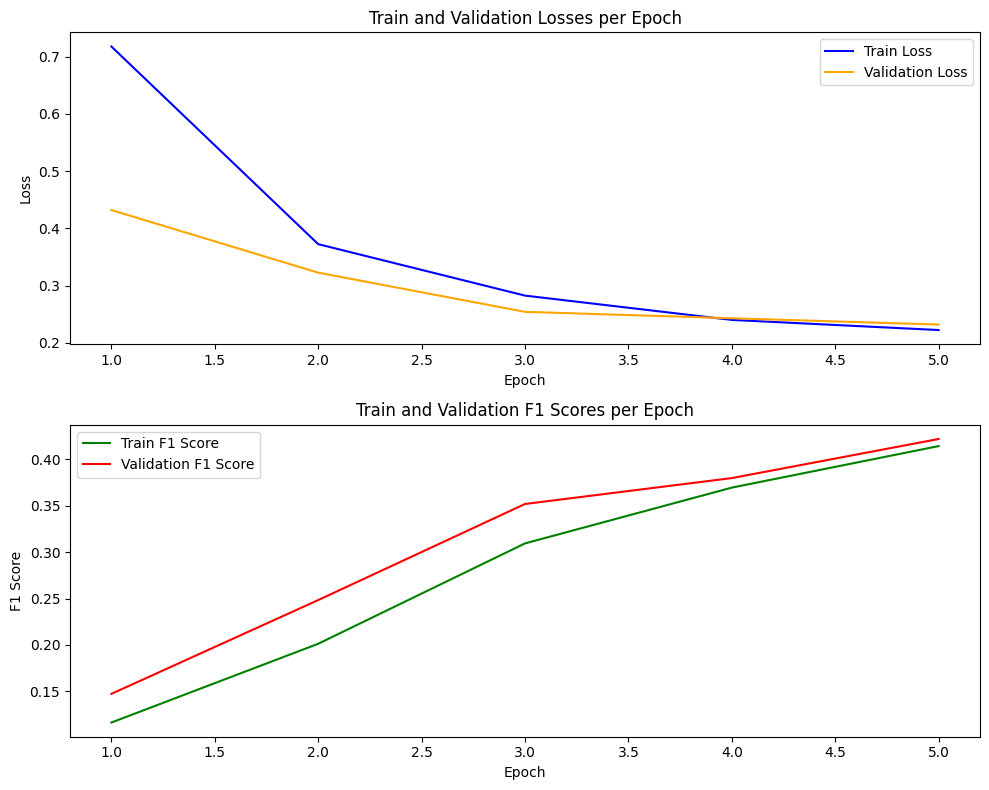

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Create subplots for losses and F1 scores
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot losses
axs[0].plot(epochs, train_losses, label='Train Loss', color='blue')
axs[0].plot(epochs, val_losses, label='Validation Loss', color='orange')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train and Validation Losses per Epoch')
axs[0].legend()

# Plot F1 scores
axs[1].plot(epochs, train_f1_scores, label='Train F1 Score', color='green')
axs[1].plot(epochs, val_f1_scores, label='Validation F1 Score', color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('F1 Score')
axs[1].set_title('Train and Validation F1 Scores per Epoch')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

In [20]:
torch.save(model, '../trained_models/t1_lstm_glove.pt')

In [ ]:
# model = torch.nn.LSTM(300, len(label_dict_LR), 2, batch_first=True)
# model = torch.nn.LSTM(300, len(label_dict_LR), 1, batch_first=True)
# model = torch.nn.GRU(300, len(label_dict_LR), 1, batch_first=True)
# model = SequentialModel(label_dict_LR)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=5)

In [ ]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9632465277777778 Test F1: 0.2976833335124903


In [ ]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9730995641591668 Test F1: 0.4869017166670912


In [ ]:
for input, label, sentence in NER_train_loader:
    print(sentence)
    outputs, hn = model(input.to(device).to(torch.float32))
    # print label and prediction
    _, predicted = torch.max(outputs, 2)
    print(label)
    print(predicted)

    print(outputs.shape)
    break
    

('The injuries of Shish Pal (D-3) are as follows: (i) Incised Wounds at (Lt) pareital area of skull at top size 12 cm x 1-1/2 cms x Brain matter deep obliquely & Tailing Backwards. (ii) Multiple Incised Wounds at (Lt) Head Laterally & at Back side. ', 'The learned Counsel for the parties informed that the matter is still not decided by the larger Bench of the Supreme Court. ', 'therefore, she was not entitled to any damages. ', 'Some of those 15 also had injuries on their persons which appeared to be due to lathi charge at village Khabra. ', 'I am unable to subscribe to the Second reasoning given by Piggott J. in AIR 1916 All 51 that if an appeal against a decree can lie in certain circumstances the decree may be regarded as one open to appeal for purposes of Order 43 Rule 1(d). ', 'According to Sri Haranahalli, the complaint as against respondent/accused No. 2 was definitely maintainable and could be proceeded with against him in view of no bar thereto under section 446 of the Compani